In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint

sys.path.append('../..')

In [2]:
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price, lrna_price, price, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math
import random

initial_omnipool_tvl = 10000000
lrna_price_usd = 22.22

omnipool = OmnipoolState(
    tokens={
        'DOT': {'liquidity': 1000000, 'LRNA': 3000000},
        'HDX': {'liquidity': 1000000000, 'LRNA': 100000000},
        'USD': {'liquidity': 10000000, 'LRNA': 10000000}
    },
    lrna_fee=0,
    asset_fee=0,
    preferred_stablecoin = 'USD',
)

agent1 = Agent(
    holdings={'DOT': 1}
)
agent2 = Agent(
    holdings={'DOT': 1}
)
agent3 = Agent(
    holdings={'DOT': 2000000, 'HDX': 20000000}
)
initial_state = GlobalState(
    pools={
        'omnipool': omnipool
    },
    agents={
        'LP1': agent1,
        'LP2': agent2
    }
)

In [3]:
print(omnipool.usd_price(omnipool, 'DOT'))
omnipool.add_liquidity(
    agent=agent1,
    quantity=1,
    tkn_add='DOT'
)
print(agent1.holdings)

3.0
{'DOT': 0, 'USD': 0, 'HDX': 0, ('omnipool', 'DOT'): 1.0}


In [4]:
omnipool.swap(
    agent=agent3.copy(),
    tkn_sell='DOT',
    tkn_buy='HDX',
    sell_quantity = 500000
)
print(agent1.holdings)

{'DOT': 0, 'USD': 0, 'HDX': 0, ('omnipool', 'DOT'): 1.0}


In [5]:
print(omnipool.usd_price(omnipool, 'DOT'))
omnipool.add_liquidity(
    agent=agent2,
    quantity=1,
    tkn_add='DOT'
)
print(agent2.holdings)

1.3333342222217777
{'DOT': 0, 'USD': 0, 'HDX': 0, ('omnipool', 'DOT'): 0.6666668888887407}


In [6]:
print(agent1, agent2)


Agent: LP1
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *USD*: 0

    *HDX*: 0

    *('omnipool', 'DOT')*: 1.0
    price: 3.0
)
 Agent: LP2
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *USD*: 0

    *HDX*: 0

    *('omnipool', 'DOT')*: 0.6666668889
    price: 1.3333342222
)



In [7]:
price_scenarios = []
for n in range(100, 0, -1):
    tkn_sell = 'HDX'
    tkn_buy = 'DOT'
    sell_quantity = agent3.holdings['HDX'] / 10000 * n ** 2
    price_scenarios.append(
        omnipool.copy().swap(
            agent=agent3.copy(),
            tkn_sell=tkn_sell,
            tkn_buy=tkn_buy,
            sell_quantity=sell_quantity
        )
    )
# price_scenarios.append(omnipool.copy())
for n in range(0, 100):
    tkn_sell = 'DOT'
    tkn_buy = 'HDX'
    sell_quantity = agent3.holdings['DOT'] / 10 * math.sqrt(n)
    price_scenarios.append(
        omnipool.copy().swap(
            agent=agent3.copy(),
            tkn_sell=tkn_sell,
            tkn_buy=tkn_buy,
            sell_quantity=sell_quantity
        )
    )

In [8]:
prices = [{tkn: lrna_price(pool, tkn) for tkn in pool.asset_list} for pool in price_scenarios]
dot_prices = [price['DOT'] for price in prices]
agent1_value = [
    cash_out_omnipool(omnipool=pool, agent=agent1, prices=prices[i])
    for i, pool in enumerate(price_scenarios)
]
agent2_value = [
    cash_out_omnipool(omnipool=pool, agent=agent2, prices=prices[i])
    for i, pool in enumerate(price_scenarios)
]

Text(0.5, 0, 'DOT price')

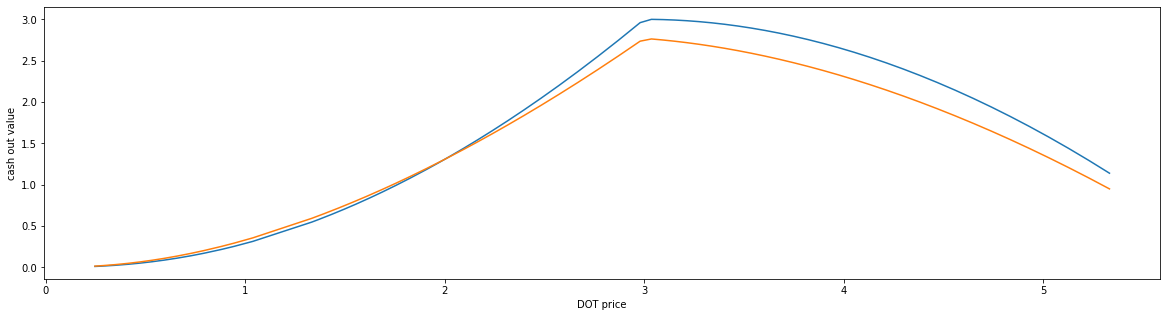

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, agent1_value)
plt.plot(dot_prices, agent2_value)
plt.ylabel('cash out value')
plt.xlabel('DOT price')

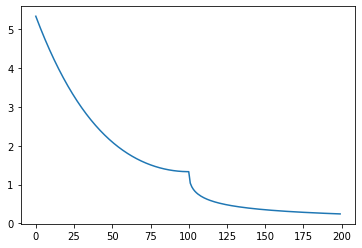

In [10]:
plt.plot(dot_prices)

In [11]:
withdraw_scenarios = []
agent1_holdings = []
agent2_holdings = []
for pool in price_scenarios:
    withdraw_scenario = pool.copy()
    test_agent1 = agent1.copy()
    test_agent2 = agent2.copy()
    withdraw_scenario.remove_liquidity(
        agent=test_agent1,
        tkn_remove='DOT',
        quantity=test_agent1.holdings[('omnipool', 'DOT')]
    )
    withdraw_scenario.remove_liquidity(
        agent=test_agent2,
        tkn_remove='DOT',
        quantity=test_agent2.holdings[('omnipool', 'DOT')]
    )
    agent1_holdings.append(test_agent1.holdings)
    agent2_holdings.append(test_agent2.holdings)

lrna_prices = [1 / lrna_price(pool, 'DOT') for pool in price_scenarios]

Text(0.5, 1.0, 'DOT returned as a function of DOT price')

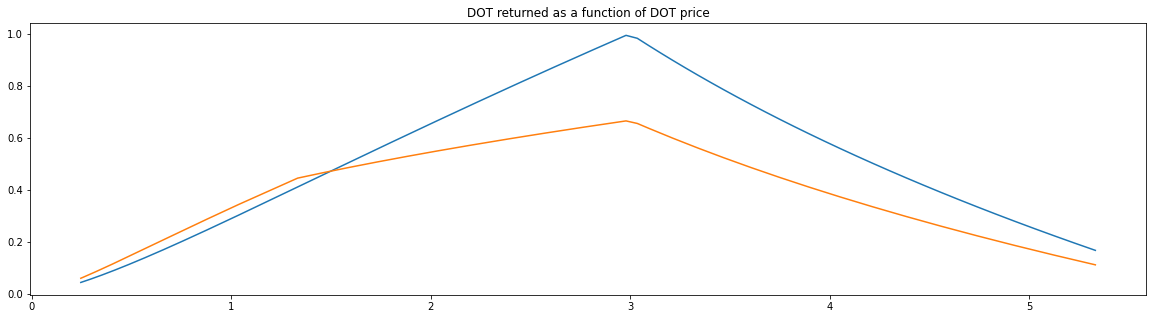

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_holdings[i]['DOT'] for i in range(len(agent1_holdings))])
plt.plot(dot_prices, [agent2_holdings[i]['DOT'] for i in range(len(agent2_holdings))])
plt.title('DOT returned as a function of DOT price')

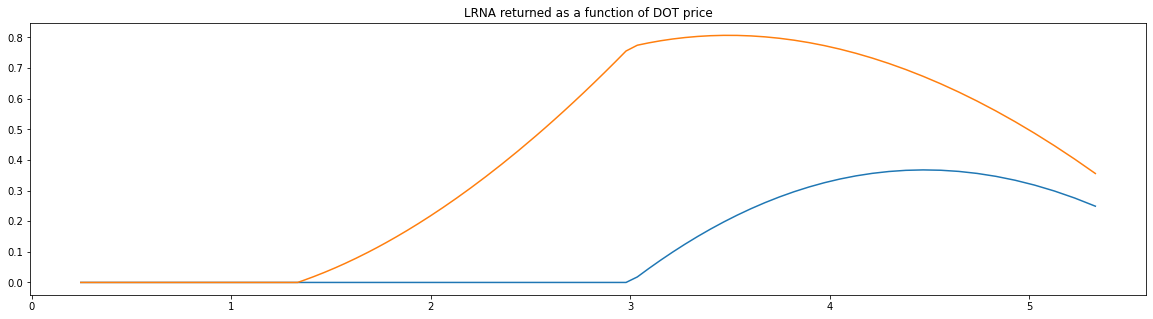

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_holdings[i]['LRNA'] if 'LRNA' in agent1_holdings[i] else 0 for i in range(len(agent1_holdings))])
plt.plot(dot_prices, [agent2_holdings[i]['LRNA'] if 'LRNA' in agent1_holdings[i] else 0 for i in range(len(agent2_holdings))])
plt.title('LRNA returned as a function of DOT price')
plt.show()

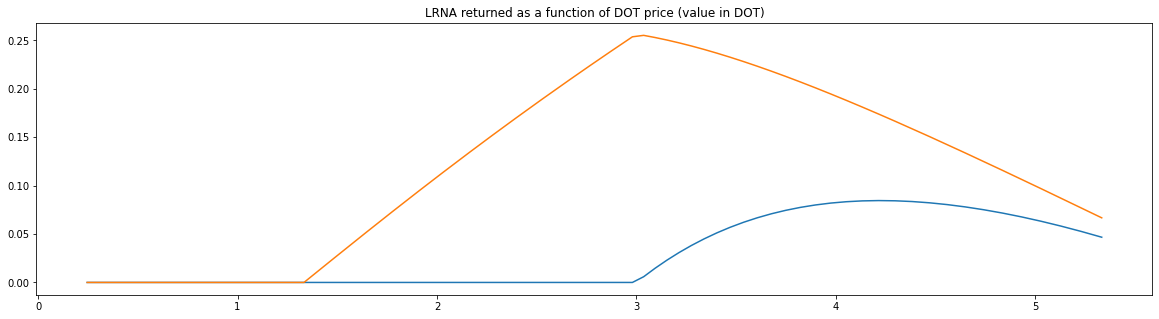

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_holdings[i]['LRNA'] / dot_prices[i] for i in range(len(agent1_holdings))])
plt.plot(dot_prices, [agent2_holdings[i]['LRNA'] / dot_prices[i] for i in range(len(agent2_holdings))])
plt.title('LRNA returned as a function of DOT price (value in DOT)')
plt.show()